# 课时67 infoGAN代码实现(MNIST数据集)

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
tf.__version__

'2.1.0'

## 1. 读取数据以及数据预处理
>需要注意的是在infoGAN中输入的condition和CGAN中的是不一样的，CGAN中的是和输入图片一一对应的了label信息，而infoGAN中的condition则是维度大小一致的任意一个向量而已(随机的noise)

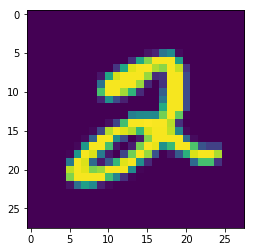

In [44]:
# 导入MNIST数据集
(train_images, train_labels),(_, _) = tf.keras.datasets.mnist.load_data()
plt.imshow(train_images[5])

In [45]:
# 对数据集进行预处理(数据归一化到[-1, 1])
train_images = train_images/127.5 - 1
# 这里CGAN采用的是DCGAN的结构，也就是卷积，因此需要将图片数据的第三个维度扩充起来
train_images = np.expand_dims(train_images, -1)

In [46]:
# 将数据转换为datasets
train_datasets = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_datasets

<TensorSliceDataset shapes: ((28, 28, 1), ()), types: (tf.float64, tf.uint8)>

In [47]:
# 定义参量，并进行数据乱序和batch批次化
BATCH_SIZE = 256
noise_dim = 100
infoGAN_condition_dim = 100
train_datasets = train_datasets.shuffle(train_images.shape[0]).batch(BATCH_SIZE)

In [48]:
train_datasets

<BatchDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float64, tf.uint8)>

## 2. 定义生成器和判别器模型

In [29]:
def generator_model():
    # 由于是三个输入，因此采用的是函数式API进行模型搭建
    noise = tf.keras.layers.Input(shape=((noise_dim,)))
    # 这里的标签值是一个单个的值，可以从train_datasets中可以看出来
    # 这个输入是label，是在这次试验中额外加入的可以控制生成图片能够生成对应的数据的标签
    # 这个输入与CGAN/ACGAN中一样，仅本试验中进行添加，实际的infoGAN中没有这一输入
    CGAN_condition_label = tf.keras.layers.Input(shape=(()))
    # 这个就是infoGAN中输入的C，也即latent space vector
    # 另外：需要注意的是infoGAN中的C一开始是不清楚它到底控制的是数据的什么方面的，需要进行测试
    # 此外，要想控制数据更多的特性的话，就增加这个infoGAN_C的个数输入到G，不同的C控制不同的特性
    infoGAN_condition_label = tf.keras.layers.Input(shape=(infoGAN_condition_dim))
    
    # 需要将输入的noise和condition_label进行合并concat
    # 在进行合并之前，由于condition_label的shape=()，不太好进行合并
    # 因此需要使用Embedding函数将其转换成我们制定shape的一个向量才好进行合并
    # 其中output_dim=100代表将condition_label映射到长度与noise长度相同的维度
    # https://www.jianshu.com/p/e8986d0ff4ff
    # https://blog.csdn.net/claroja/article/details/95196612
    # 需要注意的是input_dim代表的是整个数据的词汇表的个数，这里整个MNIST数据集也就是10个数字
    # 而input_length则代表每次输入的序列的长度。
    x = tf.keras.layers.Embedding(input_dim=10, output_dim=100, 
                                  input_length=1)(CGAN_condition_label)
    x = tf.keras.layers.concatenate([noise, x, infoGAN_condition_label])
    # 合并完成之后，现在再利用全连接层将现在合并完之后的向量转换为合适shape的向量
    # 方便后续以合适shape的向量为基准开始反卷积，知道反卷积到合适尺寸的图片大小
    x = tf.keras.layers.Dense(units=3*3*128, use_bias=False)(x)
    x = tf.keras.layers.Reshape(target_shape=(3, 3, 128))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # [7, 7, 64]
    x = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), 
                                        strides=(2, 2), use_bias=False,                                                     padding='valid')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # [14, 14, 32]
    x = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3, 3), 
                                        strides=(2, 2), use_bias=False,                                                     padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    
    # [28, 28, 1]
    x = tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=(3, 3), 
                                        strides=(2, 2), use_bias=False,                                                     padding='same')(x)
    x = tf.keras.layers.Activation('tanh')(x)
    
    model = tf.keras.Model(inputs=[noise, 
                                   CGAN_condition_label,                                                               infoGAN_condition_label], 
                           outputs=x)
    return model

In [30]:
def discriminator_model():
    # infoGAN中D网络和Q网络可以是共享的网络
    input_image = tf.keras.layers.Input(shape=((28,28,1)))

    x = tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), 
                               padding='same', use_bias=False)(input_image)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    
    x = tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), strides=(2, 2), 
                               padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    
    x = tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), strides=(2, 2), 
                               padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    
    x = tf.keras.layers.Flatten()(x)
    # 图片真假(real/fake)输出
    real_or_fake_outputs_logits = tf.keras.layers.Dense(units=1)(x)
    # 图片类别判断输出(MNIST是十分类)
    category_outputs_logits = tf.keras.layers.Dense(units=10)(x)
    # 图片的condition_label输出
    condition_outputs_logits = tf.keras.layers.Dense(units=infoGAN_condition_dim)(x)
    
    model = tf.keras.Model(inputs=input_image, 
                           outputs=[real_or_fake_outputs_logits,                                                        category_outputs_logits, 
                                    condition_outputs_logits])
    return model

## 3. 定义损失函数及优化器

In [32]:
generator = generator_model()
discriminator = discriminator_model()

In [33]:
Binary_Crossentropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
# 增加图片类别分类损失(SparseCategoricalCrossentropy)
Category_Cross_Entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [34]:
def discriminator_loss(real_image_outputs, pred_class_outs, 
                       fake_image_outputs, real_class_label,                                               condition_outputs_logits, condition_inputs):
    real_image_loss = Binary_Crossentropy(y_true=tf.ones_like(real_image_outputs),                                            y_pred=real_image_outputs)
    fake_image_loss = Binary_Crossentropy(y_true=tf.zeros_like(fake_image_outputs),                                           y_pred=fake_image_outputs)
    
    # 由于在本次试验中添加了ACGAN/CGAN中的标签输入，因此额外增加了多类别分类损失
    category_loss = Category_Cross_Entropy(y_true=real_class_label,                                                            y_pred=pred_class_outs)
    # 这个损失就是用来衡量info中输入G的latent_C和判别网络中
    # 将G_image作为输入而输出的latent_C之间的误差有多大，两者要尽量一致，因此采用平方损失
    condition_loss = tf.reduce_mean(tf.square(condition_inputs -                                                        condition_outputs_logits))
    
    d_total_loss = real_image_loss + fake_image_loss 
                 + category_loss + condition_loss
    return d_total_loss

In [35]:
def generator_loss(fake_image_outputs, pred_class_outs, real_class_label, 
                   condition_outputs_logits, condition_inputs):
    fake_image_loss = Binary_Crossentropy(y_true=tf.ones_like(fake_image_outputs),                                            y_pred=fake_image_outputs)
    category_loss = Category_Cross_Entropy(y_true=real_class_label,                                                            y_pred=pred_class_outs)
    condition_loss = tf.reduce_mean(tf.square(condition_inputs -                                                        condition_outputs_logits))
    
    g_total_loss = fake_image_loss + category_loss + condition_loss
    
    return g_total_loss

In [36]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-5)

## 4. 定义梯度更新函数

In [37]:
@tf.function
def train_step(images, labels):
    batchsize = labels.shape[0]
    noise = tf.random.normal([batchsize, noise_dim])
    condition = tf.random.normal([batchsize, infoGAN_condition_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(inputs=(noise, labels, condition),                                                  training=True)
        fake_image_out, fake_class_outs, condition_out = discriminator  (inputs=generated_images, training=True)
        real_image_out, real_class_outs, _ = discriminator(inputs=images,                                                                      training=True)
        
        generator_loss_ = generator_loss(fake_image_out, fake_class_outs, labels, 
                                         condition_out, condition)
        discriminator_loss_ = discriminator_loss(real_image_out, real_class_outs,                                                    fake_image_out, labels,                                                             condition_out, condition)
        
    generator_gradients = gen_tape.gradient(generator_loss_,                                                                    generator.trainable_variables)
    disciminator_gradients = disc_tape.gradient(discriminator_loss_,                                                                discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(generator_gradients,                                                                generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disciminator_gradients,                                                             discriminator.trainable_variables))

## 5. 定义辅助绘图函数

In [38]:
# 设置模型训练后期查看模型效果的noise和label，这里取定了之后可以在后续展示的时候展示一样的图片
noise_seed = tf.random.normal([10, noise_dim])
label_seed = np.random.randint(0, 10, size=(10))

In [39]:
def plot_generator_images(model, noise, label, epoch_num, condition):
    print('现在是第%i个epoch.'%(epoch_num))
    generated_images = model(inputs=(noise, label, condition), training=False)
    # 将shape为[None, 28, 28, 1]的图像转换为[None, 28, 28]
    generated_images = tf.squeeze(generated_images)
    fig = plt.figure(figsize=(10, 1))
    for i in range(generated_images.shape[0]):
        plt.subplot(1, 10, i+1)
        plt.imshow((generated_images[i, :, :]+1)/2, cmap='gray')
        plt.axis('off')
    plt.show()

## 6. 定义模型训练函数

In [56]:
def train(datasets, epochs):
    for epoch in range(epochs):
        print('Epoch is:', epoch)
        for images_batch, labels_batch in datasets:
            train_step(images_batch, labels_batch)
            print('.', end=' ')
        print()
        if epoch % 10 == 0:
            condition = tf.random.normal([10, infoGAN_condition_dim])
            plot_generator_images(generator, noise_seed, 
                                  label_seed, epoch, condition)
    condition = tf.random.normal([10, infoGAN_condition_dim])
    plot_generator_images(generator, noise_seed, label_seed, epoch, condition)

In [58]:
train(train_datasets, 200)

In [3]:
# 进行测试
generator.save('generate_infogan.h5')
num = 10

noise_seed = tf.random.normal([num, noise_dim])
cond = tf.convert_to_tensor(np.ones([num, infoGAN_condition_dim])*0.1)
cat_seed = np.arange(10).reshape(-1, 1)

plot_generator_images(generator, noise_seed, cat_seed, 0, cond)
print(cat_seed.T)

In [ ]:
cat_seed = np.array([3]*10)
plot_generator_images(generator, noise_seed, cat_seed, 0, cond)

In [ ]:
cond = tf.convert_to_tensor(np.ones([num, infoGAN_condition_dims])*0.9)
plot_generator_images(generator, noise_seed, cat_seed, 0, cond)

In [ ]:
cond = tf.convert_to_tensor(np.linspace(0, 1, 300).reshape(10, 30))
plot_generator_images(generator, noise_seed, cat_seed, 0, cond)

In [ ]:
cat_seed = np.array([5]*10)
plot_generator_images(generator, noise_seed, cat_seed, 0, cond)